In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



In [3]:

df = pd.read_csv("../data/raw/raw_analyst_ratings.csv")  
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [4]:
df = df.drop(columns=["Unnamed: 0"])
df.head()


,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [5]:
df["headline_length"] = df["headline"].str.len()
df[["headline", "headline_length"]].head()


,headline,headline_length
0,Stocks That Hit 52-Week Highs On Friday,39
1,Stocks That Hit 52-Week Highs On Wednesday,42
2,71 Biggest Movers From Friday,29
3,46 Stocks Moving In Friday's Mid-Day Session,44
4,B of A Securities Maintains Neutral on Agilent...,87


In [6]:
# 1) Headline length statistics
df["headline_length"].describe()


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

In [7]:
#2) Count articles per publisher
df["publisher"].value_counts().head(10)


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64

In [8]:
#3) Convert date to datetime
df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")



In [9]:
df["date_only"] = df["date"].dt.date
df["hour"] = df["date"].dt.hour
df["day_of_week"] = df["date"].dt.day_name()


<Axes: title={'center': 'Articles Per Day'}, xlabel='date_only'>

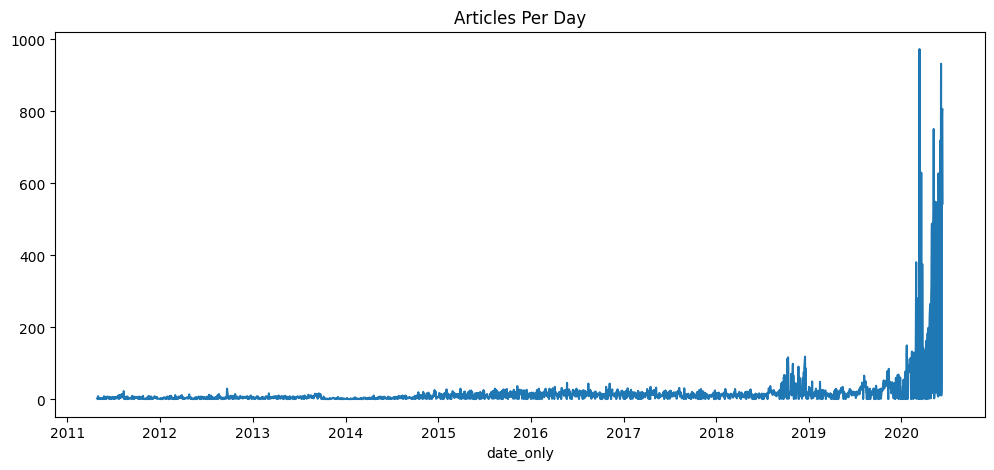

In [10]:
#Articles per day
df.groupby("date_only").size().plot(figsize=(12,5), title="Articles Per Day")

In [11]:
#Articles per hour
df.groupby("hour").size()


hour
0.0      131
1.0       82
2.0       48
3.0       27
4.0       67
5.0       14
6.0       57
7.0       93
8.0     1469
9.0     1829
10.0    2476
11.0    5033
12.0    5527
13.0    5965
14.0    7669
15.0    5701
16.0    5732
17.0    2710
18.0    2075
19.0    1612
20.0    3939
21.0    2800
22.0     704
23.0     227
dtype: int64

In [12]:
#Articles per weekday
df["day_of_week"].value_counts()


day_of_week
Thursday     12712
Wednesday    11873
Tuesday      11037
Monday       10297
Friday        9407
Sunday         388
Saturday       273
Name: count, dtype: int64

In [13]:
# Fill missing headlines
df["headline"] = df["headline"].fillna("")

# Lowercase
df["headline"] = df["headline"].str.lower()


In [14]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df["headline"])


In [15]:
k = 5  # number of topics
kmeans = KMeans(n_clusters=k, random_state=42)
df["topic"] = kmeans.fit_predict(X)


In [16]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(k):
    print(f"Topic {i}:")
    top_words = [terms[ind] for ind in order_centroids[i, :10]]  # top 10 words
    print(", ".join(top_words))
    print()


Topic 0:
earnings, shares, market, update, stocks, buy, raises, maintains, pt, price

Topic 1:
vs, est, eps, reports, sales, estimate, q4, q1, q2, q3

Topic 2:
benzinga, upgrades, downgrades, gainers, initiations, premarket, losers, volume, 2019, chatter

Topic 3:
announces, initiates, coverage, 00, pt, buy, rating, target, price, outperform

Topic 4:
stocks, 52, week, moving, session, hit, pre, highs, lows, market



In [17]:
for i in range(k):
    print(f"--- Topic {i} headlines ---")
    print(df[df["topic"]==i]["headline"].head(5).tolist())
    print()


--- Topic 0 headlines ---
['71 biggest movers from friday', 'b of a securities maintains neutral on agilent technologies, raises price target to $88', 'cfra maintains hold on agilent technologies, lowers price target to $85', 'ubs maintains neutral on agilent technologies, raises price target to $87', 'agilent technologies shares are trading higher after the company reported better-than-expected q2 eps and sales results.']

--- Topic 1 headlines ---
['agilent technologies q2 adj. eps $0.71 beats $0.61 estimate, sales $1.24b beat $1.21b estimate', 'agilent reaffirms fy20 guidance: adj. eps $3.38-$3.43 vs $3.42 estimate, sales $5.5b-$5.55b vs $5.54b est.', 'agilent sees fy20 adj. eps $3.38-$3.43 vs $3.44 estimate, sales $5.5b-$5.55b vs $5.55b est.', 'agilent sees q1 adj. eps $0.80-$0.81 vs $0.84 estimate, sales $1.34b-$1.355b vs $1.38b est.', 'agilent technologies q4 adj. eps $0.89 beats $0.85 estimate, sales $1.37b beat $1.33b estimate']

--- Topic 2 headlines ---
["benzinga's top upgra

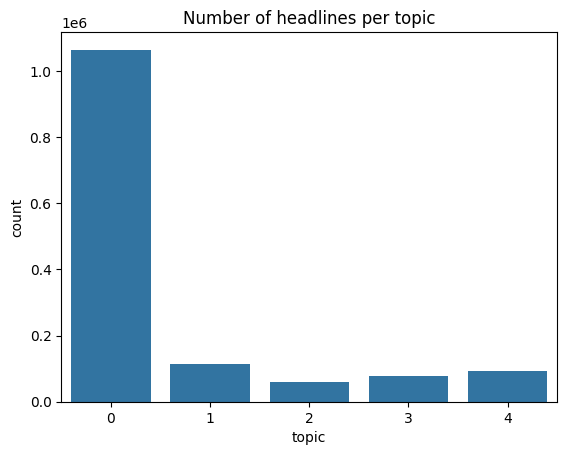

In [18]:
import seaborn as sns

sns.countplot(x="topic", data=df)
plt.title("Number of headlines per topic")
plt.show()


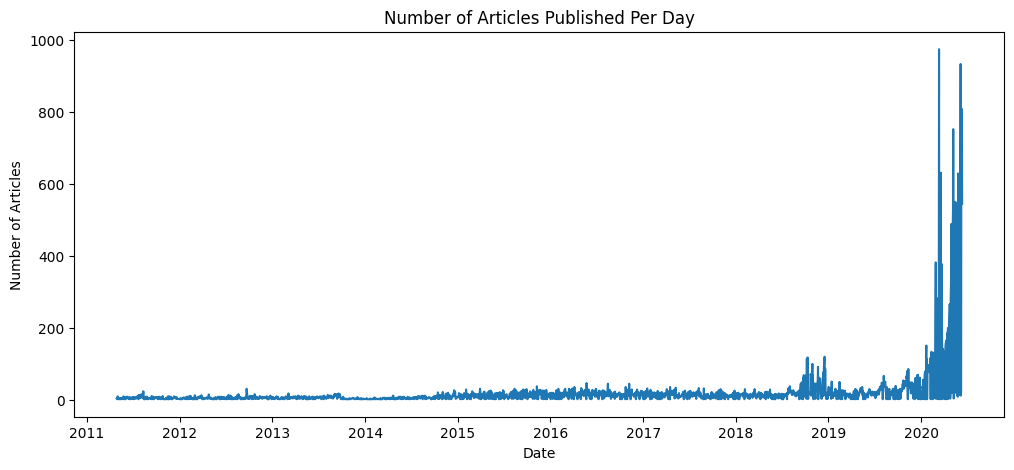

In [19]:
# Group by date only
daily_counts = df.groupby("date_only").size()

# Plot
plt.figure(figsize=(12,5))
daily_counts.plot(title="Number of Articles Published Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()

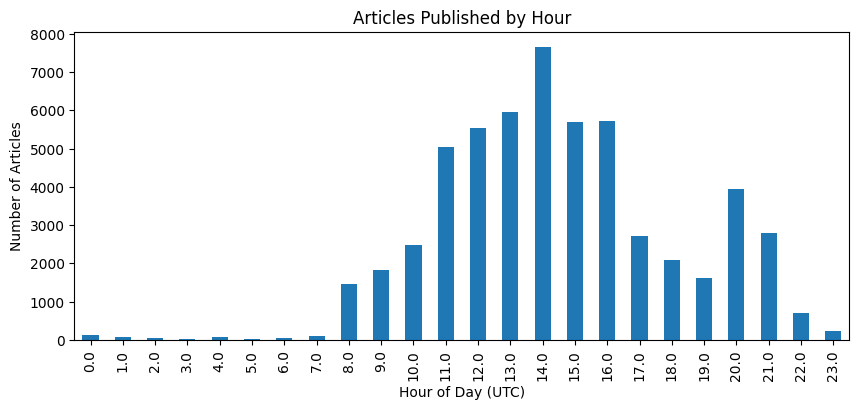

In [20]:
hourly_counts = df.groupby("hour").size()

plt.figure(figsize=(10,4))
hourly_counts.plot(kind="bar", title="Articles Published by Hour")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Number of Articles")
plt.show()


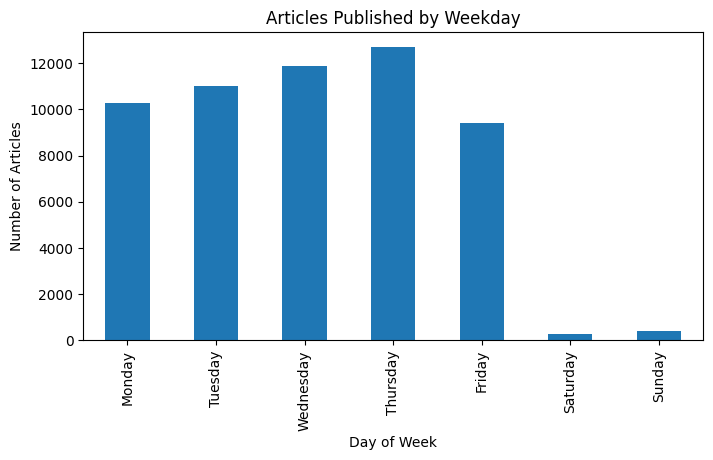

In [21]:
weekday_counts = df["day_of_week"].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

plt.figure(figsize=(8,4))
weekday_counts.plot(kind="bar", title="Articles Published by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Number of Articles")
plt.show()


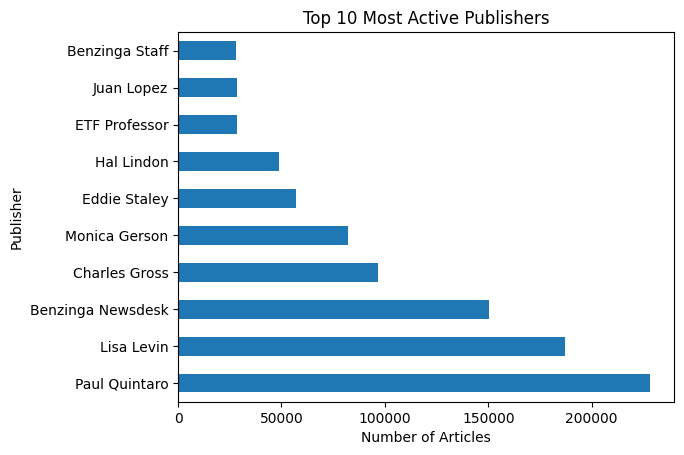

In [22]:
publisher_counts = df["publisher"].value_counts().head(10)  # top 10
publisher_counts.plot(kind="barh", title="Top 10 Most Active Publishers")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.show()


In [23]:
# Check for '@' in publisher column
df["publisher_domain"] = df["publisher"].apply(lambda x: x.split("@")[-1] if "@" in x else None)

# Count by domain
domain_counts = df["publisher_domain"].value_counts().head(10)
print(domain_counts)


publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


In [24]:
import os

# Create folder if it doesn't exist
os.makedirs("../data/processed", exist_ok=True)

# Save the cleaned news DataFrame
df.to_csv("../data/processed/news_with_topics.csv", index=False)